##### Copyright 2018 The TensorFlow Authors.

# Basic classification: Classify images of clothing

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.9.2


## Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [4]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [5]:
len(train_labels)

60000



Each label is an integer between 0 and 9:

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)


There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [7]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [8]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

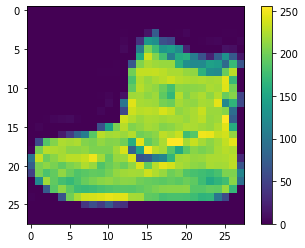

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

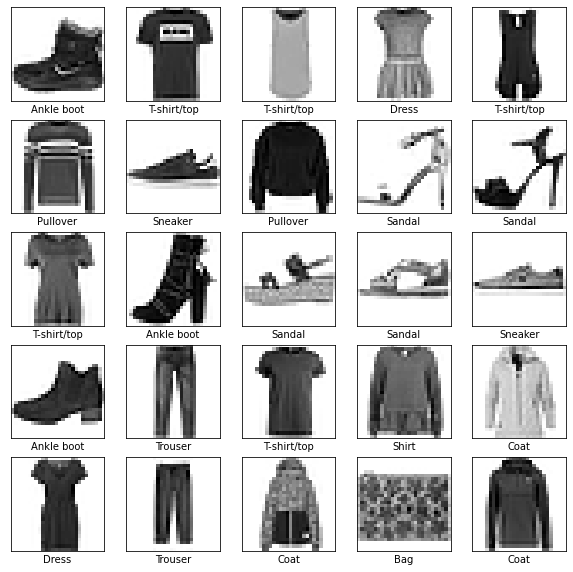

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [13]:
no_neurons=[2,4,8,16,32,64,128,256,512]
train_acc_list=[]
test_acc_list=[]

for i in no_neurons:
  model = tf.keras.Sequential([
      tf.keras.layers.Dropout(0.01),
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(i, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  acc=model.fit(train_images, train_labels, epochs=10)
  train_acc=acc.history['accuracy'][-1]
  print('\n Number of Neurons: {}'.format(i))
  print('\nTrain accuracy:', train_acc)
  train_acc_list.append(train_acc)
  test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

  print('\nTest accuracy:', test_acc)
  test_acc_list.append(test_acc)



Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 1.4597 - accuracy: 0.4603
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.1239 - accuracy: 0.5586
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0729 - accuracy: 0.5805
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0455 - accuracy: 0.5985
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0265 - accuracy: 0.6116
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1.0110 - accuracy: 0.6234
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9989 - accuracy: 0.6301
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.9903 - accuracy: 0.6355
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9822 - accuracy: 0.6397
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.975

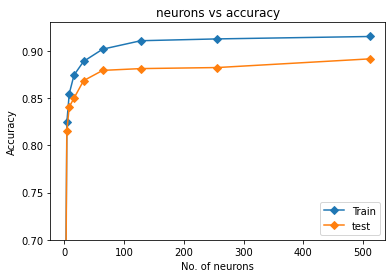

In [14]:

plt.plot(no_neurons,train_acc_list, marker='D')
plt.title('neurons vs accuracy')
plt.xlabel('No. of neurons')
plt.ylabel('Accuracy')
plt.ylim([0.70, 0.93])
plt.plot(no_neurons,test_acc_list, marker='D')
plt.legend(["Train", "test"], loc=0, frameon=True)
plt.show()


### Experiment of changing dropout layers

We will keep number of neurons constant as 128

In [15]:
drop_out_per=[0.8,0.5,0.25,0.1,0.05,0.01]
train_acc_list=[]
test_acc_list=[]

for i in drop_out_per:
  model = tf.keras.Sequential([
      tf.keras.layers.Dropout(i),
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  acc=model.fit(train_images, train_labels, epochs=10)
  train_acc=acc.history['accuracy'][-1]
  print('\n Drop out percentage: {}'.format(i))
  print('\nTrain accuracy:', train_acc)
  train_acc_list.append(train_acc)
  test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

  print('\nTest accuracy:', test_acc)
  test_acc_list.append(test_acc)



Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.8222 - accuracy: 0.6979
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6615 - accuracy: 0.7518
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6163 - accuracy: 0.7667
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5925 - accuracy: 0.7770
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5811 - accuracy: 0.7808
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5640 - accuracy: 0.7879
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5604 - accuracy: 0.7885
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5534 - accuracy: 0.7905
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5469 - accuracy: 0.7945
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.543

[0.8, 0.5, 0.25, 0.1, 0.05, 0.01]


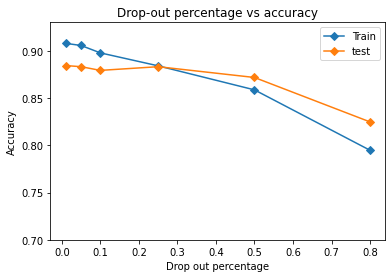

In [16]:

print(drop_out_per)
plt.plot(drop_out_per,train_acc_list, marker='D')
plt.title('Drop-out percentage vs accuracy')
plt.xlabel('Drop out percentage')
plt.ylabel('Accuracy')
plt.ylim([0.70, 0.93])
plt.plot(drop_out_per,test_acc_list, marker='D')
plt.legend(["Train", "test"], loc=0, frameon=True)
plt.show()


### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [17]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [18]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [19]:
predictions[0]

array([1.7286725e-07, 1.2348022e-07, 5.8531056e-09, 8.9000023e-12,
       5.3487767e-08, 4.0343013e-03, 1.4825457e-07, 2.2053119e-02,
       3.3882948e-08, 9.7391206e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [20]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [21]:
test_labels[0]

9

Graph this to look at the full set of 10 class predictions.

In [22]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

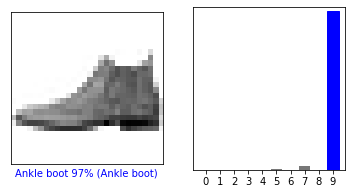

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

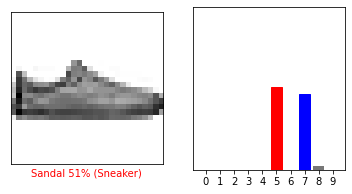

In [24]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

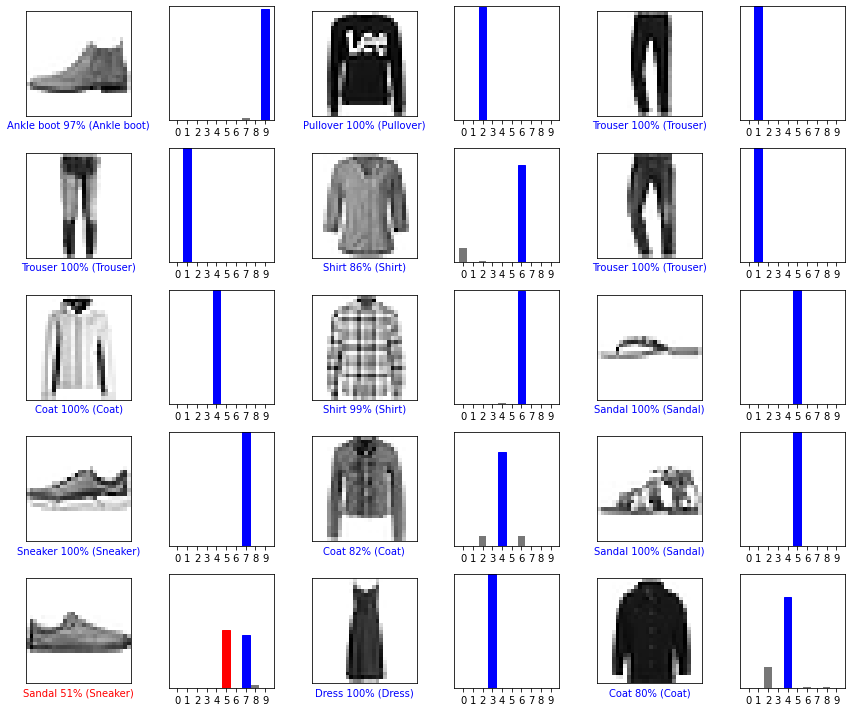

In [25]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [26]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [27]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


Now predict the correct label for this image:

In [28]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 19ms/step
[[9.41760227e-05 1.20310515e-11 9.98726428e-01 1.80439974e-09
  3.42913467e-04 1.42031970e-10 8.36526859e-04 2.40474551e-13
  6.74088119e-09 1.63554966e-12]]


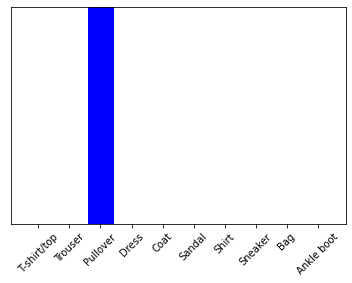

In [29]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [30]:
np.argmax(predictions_single[0])

2

And the model predicts a label as expected.